# MultiVelo Fig6

Data for this figure can be found at the links below:

RNA: https://figshare.com/account/projects/164308/articles/22575376

ATAC: https://figshare.com/account/projects/164308/articles/22575370

If you do not download them manually, the notebook will do so automatically.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sys
import multivelo as mv
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import requests

In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [3]:
rna_url = "https://figshare.com/ndownloader/files/40064350"
atac_url = "https://figshare.com/ndownloader/files/40064347"
  
rna_path = "human_brain_rna_after_filt_r2.h5ad"
atac_path = "human_brain_atac_gene_after_filt_r2.h5ad" 

In [4]:
adata_rna = sc.read(rna_path, backup_url=rna_url)
adata_atac = sc.read(atac_path, backup_url=atac_url)

  0%|          | 0.00/93.5M [00:00<?, ?B/s]

  0%|          | 0.00/45.5M [00:00<?, ?B/s]

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

### WARNING:

The recover_dynamics_chrom() step can take a long time, even with parallelization. As such, we added a h5ad file to figshare containing the AnnData object returned by recover_dynamics_chrom(). In absence of a local h5ad file of the same name, a cell below the recover_dynamics_chrom() step will download it automatically using sc.read(). If you want to run this notebook in shorter amount of time, then you can run that cell first and skip the preprocessing done in the cells above it. However, if you want to run all cells, including the preprocessing steps, the notebook will write and save the h5ad file itself rather than downloading it from figshare.

recovering dynamics (using 1/10 cores)


  0%|          | 0/509 [00:00<?, ?gene/s]

    finished (0:03:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/4693 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


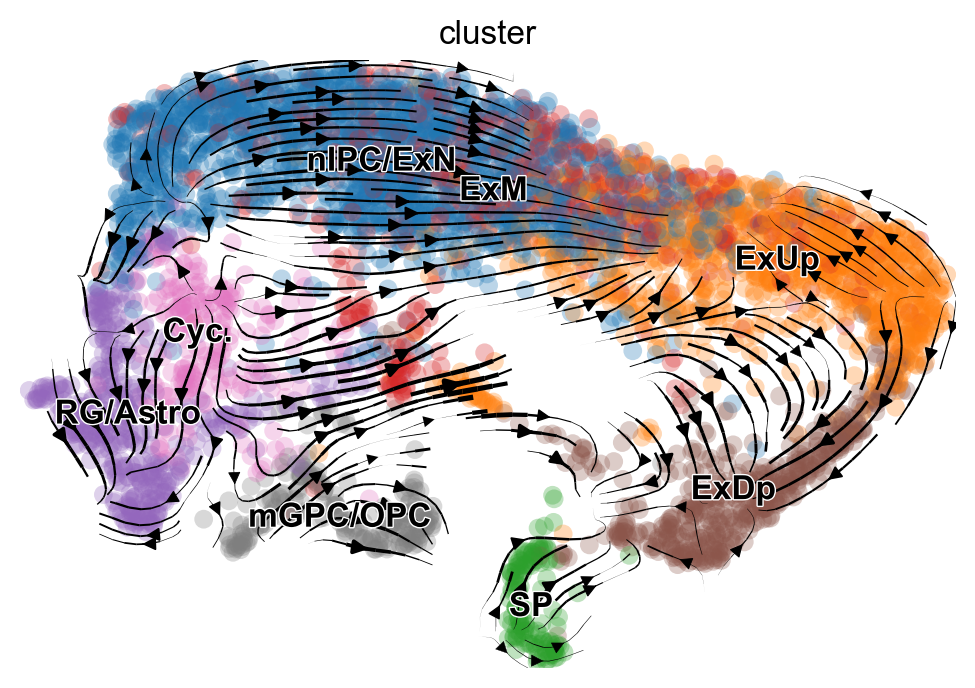

In [5]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='cluster')

In [7]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        max_iter=5, 
                                        init_mode="invert", 
                                        verbose=False,
                                        parallel=True,
                                        n_jobs = 15,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500, 
                                        extra_color_key='cluster'
                                        )

  0%|          | 0/954 [00:00<?, ?it/s]

In [8]:
# Save the result for use later on
adata_result.write("multivelo_result_fig6.h5ad")

In [3]:
h5ad_url = "https://figshare.com/ndownloader/files/40064449"
adata_result = sc.read("multivelo_result_fig6.h5ad", backup_url = h5ad_url)

## Computing velocity stream and latent time

In [4]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


  0%|          | 0/4693 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


## Fig 6a

computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


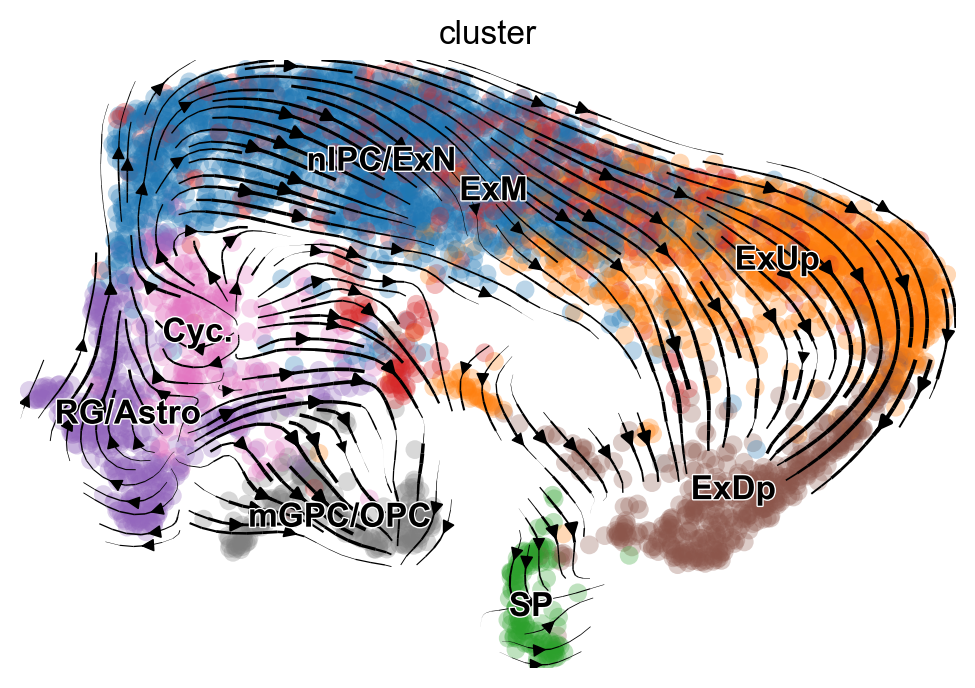

In [5]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='cluster', show=True)

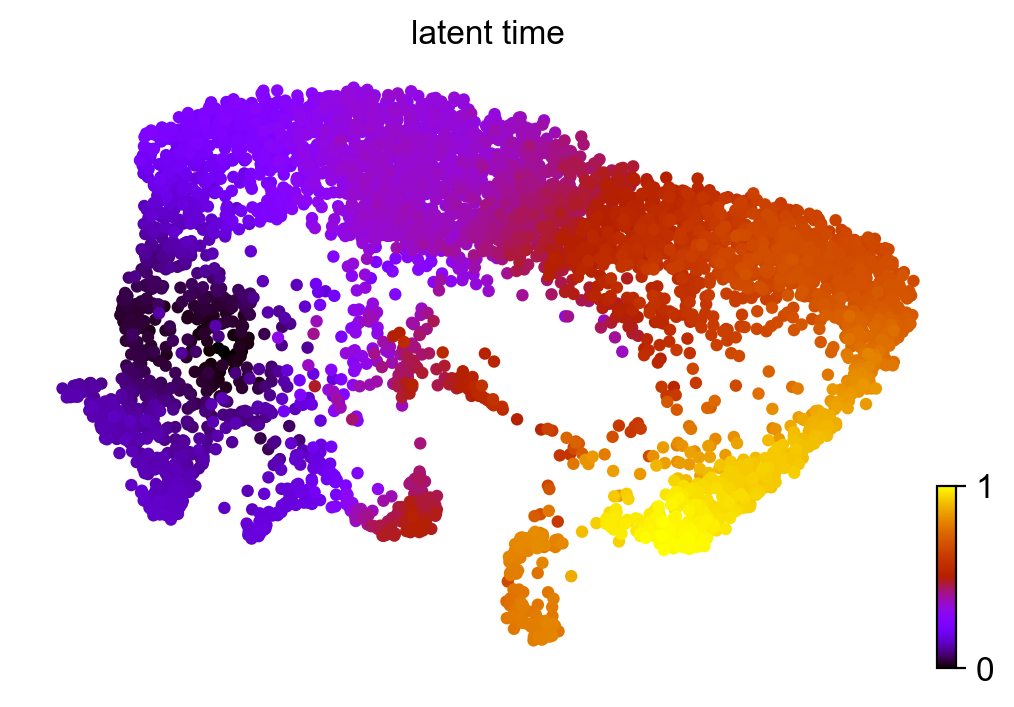

In [6]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

## Fig 6b

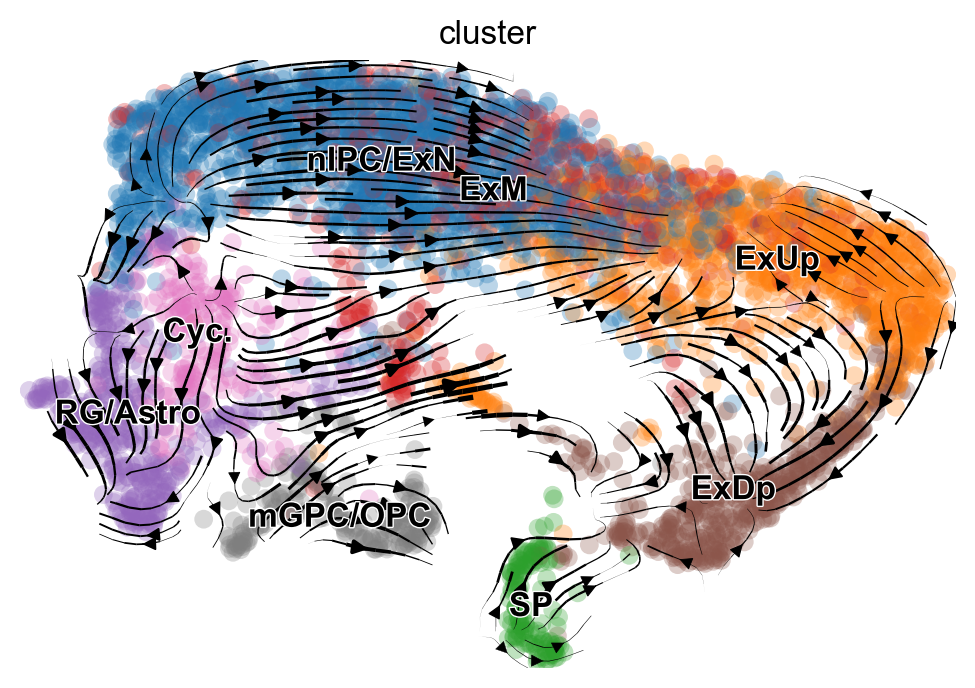

In [7]:
scv.pl.velocity_embedding_stream(adata_result, basis='umap', color='cluster')

## Fig 6c

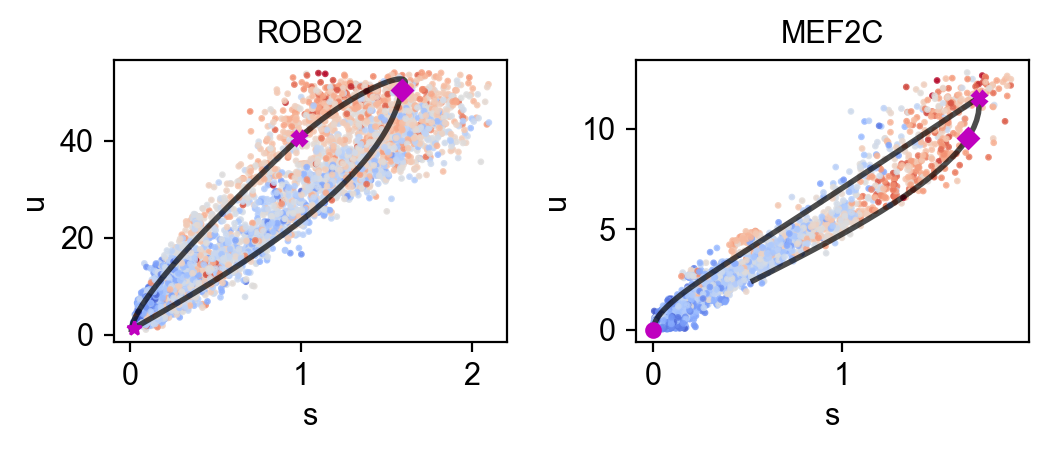

In [8]:
gene_list = ["ROBO2", "MEF2C"]
mv.scatter_plot(adata_result, color_by='c', genes=gene_list)

## Fig 6d

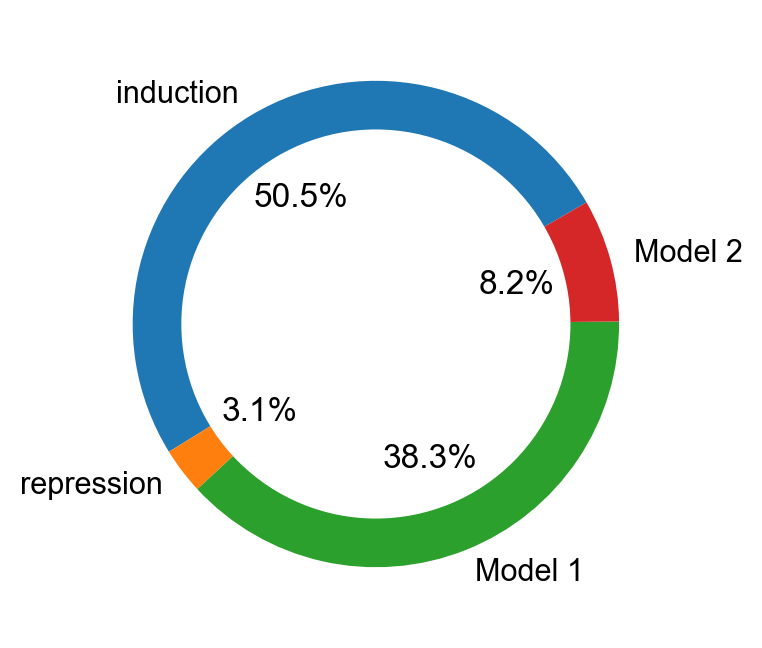

In [9]:
mv.pie_summary(adata_result)